# Multi-fidelity Multi-objective Bayesian Optimization

Here we attempt to solve for the constrained Pareto front of the TNK multi-objective
optimization problem using Multi-Fidelity Multi-Objective Bayesian optimization. For
simplicity we assume that the objective and constraint functions at lower fidelities is
exactly equal to the functions at higher fidelities (this is obviously not a
requirement, although for the best results lower fidelity calculations should
correlate with higher fidelity ones). The algorithm should learn this relationship
and use information gathered at lower fidelities to gather samples to improve the
hypervolume of the Pareto front at the maximum fidelity.

TNK function
$n=2$ variables:
$x_i \in [0, \pi], i=1,2$

Objectives:
- $f_i(x) = x_i$

Constraints:
- $g_1(x) = -x_1^2 -x_2^2 + 1 + 0.1 \cos\left(16 \arctan \frac{x_1}{x_2}\right) \le 0$
- $g_2(x) = (x_1 - 1/2)^2 + (x_2-1/2)^2 \le 0.5$

In [1]:
# set values if testing
import os
SMOKE_TEST = os.environ.get("SMOKE_TEST")
N_MC_SAMPLES = 1 if SMOKE_TEST else 128
NUM_RESTARTS = 1 if SMOKE_TEST else 20
BUDGET = 0.02 if SMOKE_TEST else 10

# Ignore all warnings
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import torch

from xopt import Xopt, Evaluator
from xopt.generators.bayesian import MultiFidelityGenerator
from xopt.resources.test_functions.tnk import evaluate_TNK, tnk_vocs

evaluator = Evaluator(function=evaluate_TNK)
print(tnk_vocs.dict())

{'variables': {'x1': [0.0, 3.14159], 'x2': [0.0, 3.14159]}, 'constraints': {'c1': ['GREATER_THAN', 0.0], 'c2': ['LESS_THAN', 0.5]}, 'objectives': {'y1': 'MINIMIZE', 'y2': 'MINIMIZE'}, 'constants': {'a': 'dummy_constant'}, 'linked_variables': {}}


## Set up the Multi-Fidelity Multi-objective optimization algorithm
Here we create the Multi-Fidelity generator object which can solve both single and
multi-objective optimization problems depending on the number of objectives in VOCS.
We specify a cost function as a function of fidelity parameter $s=[0,1]$ as $C(s) =
s^{3.5}$ as an example from a real life multi-fidelity simulation problem.

In [2]:
from copy import deepcopy
my_vocs = deepcopy(tnk_vocs)
my_vocs.constraints = {}
generator = MultiFidelityGenerator(vocs=my_vocs, reference_point = {"y1":1.5,"y2":1.5})

# set cost function according to approximate scaling of laser plasma accelerator
# problem, see https://journals.aps.org/prresearch/abstract/10.1103/PhysRevResearch.5.013063
generator.cost_function = lambda s: s**3.5
generator.optimization_options.num_restarts = NUM_RESTARTS
generator.acquisition_options.monte_carlo_samples = N_MC_SAMPLES

X = Xopt(generator=generator, evaluator=evaluator, vocs=my_vocs)

# evaluate at some explicit initial points
X.evaluate_data(pd.DataFrame({"x1":[1.0, 0.75],"x2":[0.75, 1.0],"s":[0.0,0.1]}))

X


            Xopt
________________________________
Version: 1.4.0+5.g4492577.dirty
Data size: 2
Config as YAML:
xopt: {asynch: false, strict: false, dump_file: null, max_evaluations: null}
generator:
  name: multi_fidelity
  supports_batch_generation: true
  supports_multi_objective: true
  model_constructor:
    name: standard
    use_low_noise_prior: true
    covar_modules: {}
    mean_modules: {}
    dtype: torch.float64
    device: cpu
  optimization_options: {raw_samples: 20, num_restarts: 20, sequential: true, max_travel_distances: null,
    use_turbo: false}
  acquisition_options: {proximal_lengthscales: null, use_transformed_proximal_weights: true,
    monte_carlo_samples: 128}
  model: null
  turbo_state: null
  use_cuda: false
  reference_point: {y1: 1.5, y2: 1.5, s: 0.0}
  fidelity_parameter: s
  cost_function: __main__.<lambda>
evaluator:
  function: xopt.resources.test_functions.tnk.evaluate_TNK
  max_workers: 1
  function_kwargs: {sleep: 0, random_sleep: 0, raise_probabil

## Run optimization routine
Instead of ending the optimization routine after an explict number of samples we end
optimization once a given optimization budget has been exceeded. WARNING: This will
slightly exceed the given budget

In [3]:
budget = BUDGET
while X.generator.calculate_total_cost() < budget:
    X.step()
    print(f"n_samples: {len(X.data)} "
          f"budget used: {X.generator.calculate_total_cost():.4} "
          f"hypervolume: {X.generator.calculate_hypervolume():.4}")

n_samples: 3 budget used: 0.01027 hypervolume: 0.0375
n_samples: 4 budget used: 0.01675 hypervolume: 0.0375
n_samples: 5 budget used: 0.0266 hypervolume: 0.2392
n_samples: 6 budget used: 0.0366 hypervolume: 0.5264
n_samples: 7 budget used: 0.05751 hypervolume: 0.7453
n_samples: 8 budget used: 0.1106 hypervolume: 0.9725
n_samples: 9 budget used: 0.2362 hypervolume: 1.244
n_samples: 10 budget used: 0.5101 hypervolume: 1.554
n_samples: 11 budget used: 1.023 hypervolume: 1.818
n_samples: 12 budget used: 1.934 hypervolume: 2.191
n_samples: 13 budget used: 2.934 hypervolume: 2.25
n_samples: 14 budget used: 3.934 hypervolume: 2.25
n_samples: 15 budget used: 4.934 hypervolume: 2.25
n_samples: 16 budget used: 5.934 hypervolume: 2.25
n_samples: 17 budget used: 6.934 hypervolume: 2.25
n_samples: 18 budget used: 7.846 hypervolume: 2.25
n_samples: 19 budget used: 7.929 hypervolume: 2.25
n_samples: 20 budget used: 7.929 hypervolume: 2.25
n_samples: 21 budget used: 7.955 hypervolume: 2.25
n_samples: 

## Show results

In [4]:
X.data

,x1,x2,s,y1,y2,c1,c2,some_array,xopt_runtime,xopt_error,a
1,1.000000,0.750000,0.000000,1.000000,0.750000,0.626888,0.312500,"[1, 2, 3]",0.000027,False,NaN
2,0.750000,1.000000,0.100000,0.750000,1.000000,0.626888,0.312500,"[1, 2, 3]",0.000007,False,NaN
3,0.340237,1.690864,0.267884,0.340237,1.690864,2.074720,1.443682,"[1, 2, 3]",0.000020,False,dummy_constant
4,1.670282,3.110377,0.237034,1.670282,3.110377,11.467383,8.183626,"[1, 2, 3]",0.000021,False,dummy_constant
5,0.000000,0.902961,0.267076,0.000000,0.902961,-0.284662,0.412377,"[1, 2, 3]",0.000019,False,dummy_constant
6,0.000000,0.192005,0.268280,0.000000,0.192005,-1.063134,0.344861,"[1, 2, 3]",0.000023,False,dummy_constant
7,0.000000,0.000000,0.331234,0.000000,0.000000,-1.100000,0.500000,"[1, 2, 3]",0.000020,False,dummy_constant
8,0.000000,0.000000,0.432221,0.000000,0.000000,-1.100000,0.500000,"[1, 2, 3]",0.000021,False,dummy_constant
9,0.000000,0.000000,0.552820,0.000000,0.000000,-1.100000,0.500000,"[1, 2, 3]",0.000025,False,dummy_constant
10,0.000000,0.000000,0.690717,0.000000,0.000000,-1.100000,0.500000,"[1, 2, 3]",0.000021,False,dummy_constant


## Plot results
Here we plot the resulting observations in input space, colored by feasibility
(neglecting the fact that
these data points are at varying fidelities).


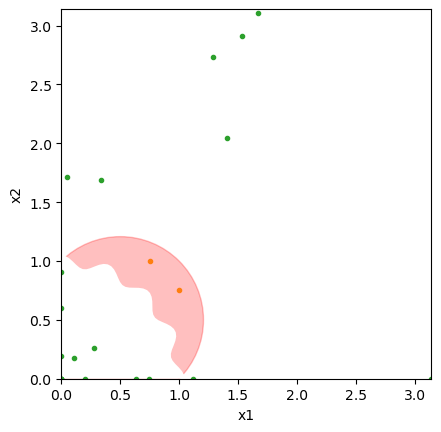

In [5]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()

theta = np.linspace(0, np.pi / 2)
r = np.sqrt(1 + 0.1 * np.cos(16 * theta))
x_1 = r * np.sin(theta)
x_2_lower = r * np.cos(theta)
x_2_upper = (0.5 - (x_1 - 0.5) ** 2) ** 0.5 + 0.5

z = np.zeros_like(x_1)

# ax2.plot(x_1, x_2_lower,'r')
ax.fill_between(x_1, z, x_2_lower, fc="white")
circle = plt.Circle(
    (0.5, 0.5), 0.5 ** 0.5, color="r", alpha=0.25, zorder=0, label="Valid Region"
)
ax.add_patch(circle)
history = pd.concat(
    [X.data, tnk_vocs.feasibility_data(X.data)], axis=1, ignore_index=False
)

ax.plot(*history[["x1", "x2"]][history["feasible"]].to_numpy().T, ".C1")
ax.plot(*history[["x1", "x2"]][~history["feasible"]].to_numpy().T, ".C2")

ax.set_xlim(0, 3.14)
ax.set_ylim(0, 3.14)
ax.set_xlabel("x1")
ax.set_ylabel("x2")
ax.set_aspect("equal")

### Plot path through input space

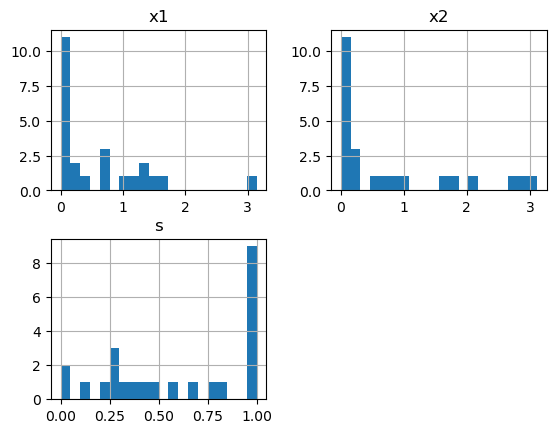

In [6]:
ax = history.hist(["x1", "x2", "s"],bins=20)

<Axes: >

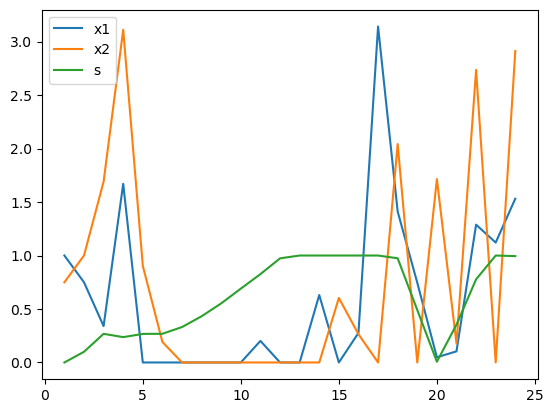

In [7]:
history.plot(y=["x1", "x2", "s"])

## Plot the acqusisition function
Here we plot the acquisition function at a small set of fidelities $[0, 0.5, 1.0]$.

[[2.1007117  2.95787686]]


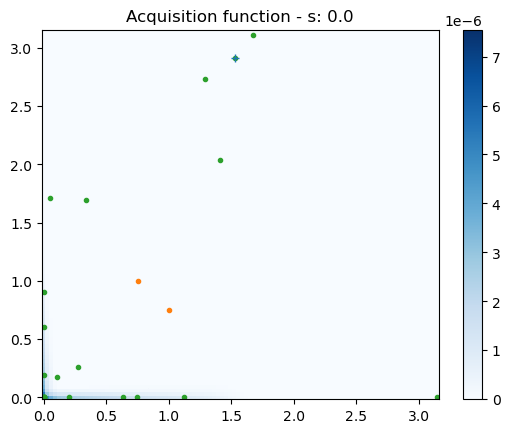

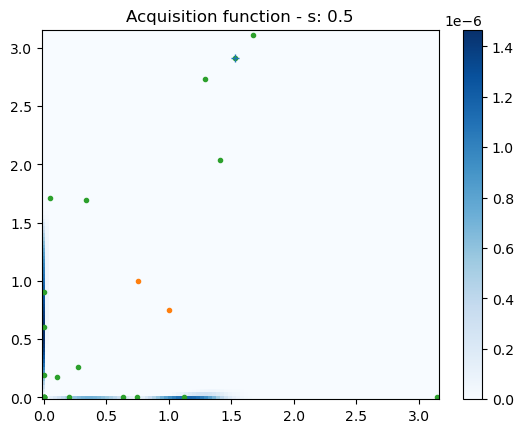

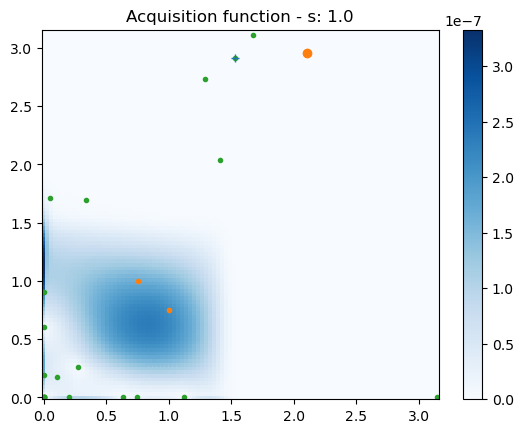

In [8]:
# plot the acquisition function
from xopt.generators.bayesian.objectives import feasibility

bounds = generator.vocs.bounds
model = generator.model

# create mesh over non-fidelity parameters
n = 100
x = torch.linspace(*bounds.T[1], n)
y = torch.linspace(*bounds.T[2], n)
xx, yy = torch.meshgrid(x, y)

# plot function(s) at a single fidelity parameter
fidelities = [0.0, 0.5, 1.0]
for fidelity in fidelities:
    pts = torch.hstack([ele.reshape(-1, 1) for ele in (xx, yy)]).double()
    pts = torch.cat((torch.ones(pts.shape[0],1)*fidelity, pts), dim=-1)

    acq_func = generator.get_acquisition(model)
    with torch.no_grad():
        acq_pts = pts.unsqueeze(1)
        acq = acq_func(acq_pts)

        fig, ax = plt.subplots()
        c = ax.pcolor(xx, yy, acq.reshape(n, n), cmap="Blues")
        fig.colorbar(c)
        ax.set_title(f"Acquisition function - s: {fidelity}")

        ax.plot(*history[["x1", "x2"]][history["feasible"]].to_numpy().T, ".C1")
        ax.plot(*history[["x1", "x2"]][~history["feasible"]].to_numpy().T, ".C2")

        ax.plot(*history[["x1", "x2"]].to_numpy()[-1].T, "+")


candidate = generator.generate(1)
print(candidate[["x1", "x2"]].to_numpy())
ax.plot(*candidate[["x1", "x2"]].to_numpy()[0], "o")

In [9]:
# examine lengthscale of the first objective
list(model.models[0].named_parameters())

[('likelihood.noise_covar.raw_noise',
  Parameter containing:
  tensor([-24.4039], dtype=torch.float64, requires_grad=True)),
 ('mean_module.raw_constant',
  Parameter containing:
  tensor(-0.1595, dtype=torch.float64, requires_grad=True)),
 ('covar_module.raw_outputscale',
  Parameter containing:
  tensor(-0.0275, dtype=torch.float64, requires_grad=True)),
 ('covar_module.base_kernel.raw_lengthscale',
  Parameter containing:
  tensor([[0.4737, 1.4647, 1.4445]], dtype=torch.float64, requires_grad=True))]

In [10]:
# dump results to file
X.options.dump_file = "results.yaml"
X.dump_state()